In [4]:
# For data manipulation
import pandas as pd

# To fetch financial data
import yfinance as yf

# For visualisation
import matplotlib.pyplot as plt

import numpy as np
import numpy

In [1]:
# Summary Statistics Function (reads in a dataframe, uses native pandas .describe() method and then appends other summary statistics to it and removes quantiles)
def describe_stats(df):

    df = pd.DataFrame(df)
    df_described = df.describe().fillna(0) 

    # Caluclate the t
    df_described.loc['t'] = df_described.loc['mean']/(df_described.loc['std']/numpy.sqrt(df_described.loc['count']))
    # Calculate the ppos
    df_described.loc['ppos'] = df[df > 0].describe().loc['count']/df_described.loc['count']
    df_described.loc['uwin'] = df[ df > 0].mean()
    df_described.loc['uloss'] = df[ df < 0].mean()
    # Remove percntages
    df_described.drop(['25%'], inplace = True)
    df_described.drop(['50%'], inplace = True)
    df_described.drop(['75%'], inplace = True)

    # Remove infinite values and nan values
    df_described.replace( numpy.inf, 0, inplace = True)
    df_described.replace(-numpy.inf, 0, inplace = True)
    df_described.replace( numpy.nan, 0, inplace = True)


    row_order = 'count max min mean ppos std t ser_corr'

    df_described.reindex(row_order.split())

    return df_described


In [2]:
def get_results_df(df):
    result_df = pd.DataFrame(columns=['count', 'mean', 'std', 'min', 'max', 't', 'ppos'])
    for i in range(1, 65): # from 1 days ahead to 65 days ahead
        # concat to the previously made blank dataframe, the % change over the current period since the condition was true via the function we use to describe the stats.
        result_df = pd.concat([result_df, describe_stats(df['Close'].pct_change(periods=i).where(df['condition'].shift(i)==True)).T], ignore_index=True)
        # the index is going to be our hold time so we have to add 1 because it starts at 0 when we created a blank dataframe to hold everything.  
        result_df.index = result_df.index + 1
    

    result_df['mean'] = result_df['mean']*100
    result_df['std'] = result_df['std']*100
    result_df['min'] = result_df['min']*100
    result_df['max'] = result_df['max']*100
    result_df['ppos'] = result_df['ppos']*100
    result_df['uwin'] = result_df['uwin']*100
    result_df['uloss'] = result_df['uloss']*100
    result_df.index.name = "Hold Time"
    result_df.rename(columns = {'count':'N', 'mean':'% Return','std':'Return STD', 'min':'Worst Return', 'max':'Best Return',
                            't':'T-stat', 'ppos':'Win Rate', 'uwin':'Average Win %', 'uloss':'Average Loss %'}, inplace = True) 

    result_df2 = result_df.T
    result_df2 = result_df2.iloc[:][[1, 2, 3, 5, 10, 20, 40, 60]]
    result_df2.rename(columns = {1:'1 Day Later', 2:'2 Days Later',3:'3 Days Later', 5:'1 Week Later', 10:'2 Weeks Later',
                            20:'1 Month Later', 40:'2 Months Later', 60:'Next Quarter'}, inplace = True) 
    return round(result_df2, 2)

In [5]:
df = yf.download("^N225", start="1930-01-01")

[*********************100%***********************]  1 of 1 completed


In [6]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1965-01-05,1257.719971,1257.719971,1257.719971,1257.719971,1257.719971,0
1965-01-06,1263.989990,1263.989990,1263.989990,1263.989990,1263.989990,0
1965-01-07,1274.270020,1274.270020,1274.270020,1274.270020,1274.270020,0
1965-01-08,1286.430054,1286.430054,1286.430054,1286.430054,1286.430054,0
1965-01-12,1288.540039,1288.540039,1288.540039,1288.540039,1288.540039,0
...,...,...,...,...,...,...
2023-08-02,33123.121094,33158.578125,32628.289062,32707.689453,32707.689453,124200000
2023-08-03,32375.849609,32467.060547,32142.250000,32159.279297,32159.279297,120300000
2023-08-04,32019.060547,32294.699219,31934.349609,32192.750000,32192.750000,106600000


In [7]:

df['condition'] = (df.index.dayofyear >= 300)
df['condition'] = (df['condition'] == True) & (df['condition'].shift(1) == False) 
get_results_df(df)

Hold Time,1 Day Later,2 Days Later,3 Days Later,1 Week Later,2 Weeks Later,1 Month Later,2 Months Later,Next Quarter
N,58.00,58.00,58.00,58.00,58.00,58.00,58.00,58.00
% Return,0.17,0.62,0.90,1.28,0.84,1.67,3.14,4.73
Return STD,1.41,2.38,3.86,4.33,5.25,6.68,8.51,10.17
Worst Return,-4.26,-3.51,-4.08,-4.48,-8.99,-15.69,-15.22,-20.08
Best Return,6.41,14.64,26.06,27.25,22.99,14.66,20.82,27.35
T-stat,0.93,1.98,1.77,2.26,1.22,1.90,2.81,3.54
Win Rate,55.17,65.52,63.79,62.07,58.62,62.07,56.90,68.97
Average Win %,0.98,1.52,2.22,3.05,3.96,5.85,9.08,9.83
Average Loss %,-0.82,-1.11,-1.43,-1.61,-3.59,-5.17,-4.71,-6.59


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


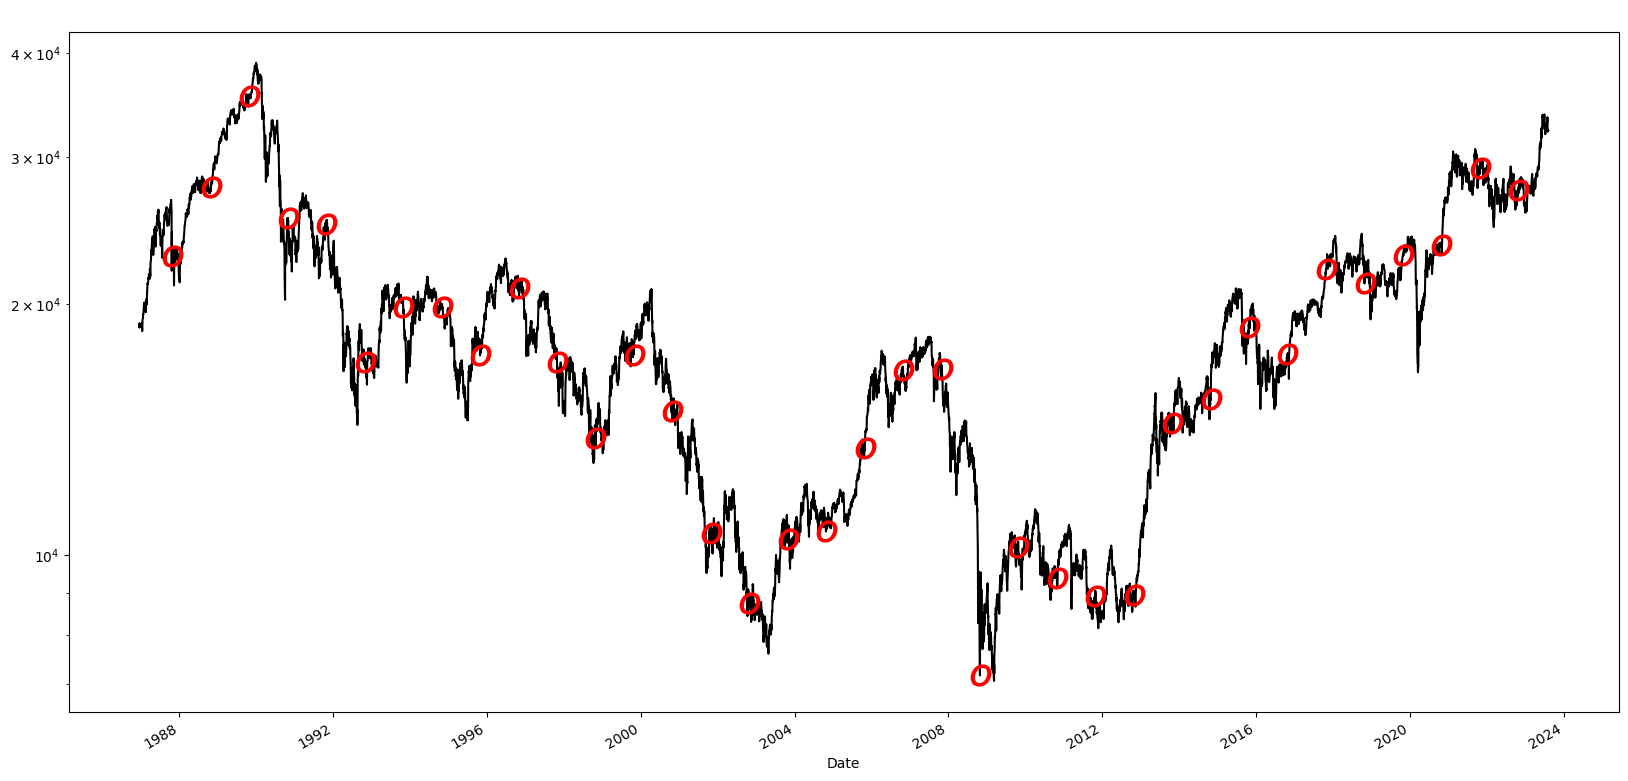

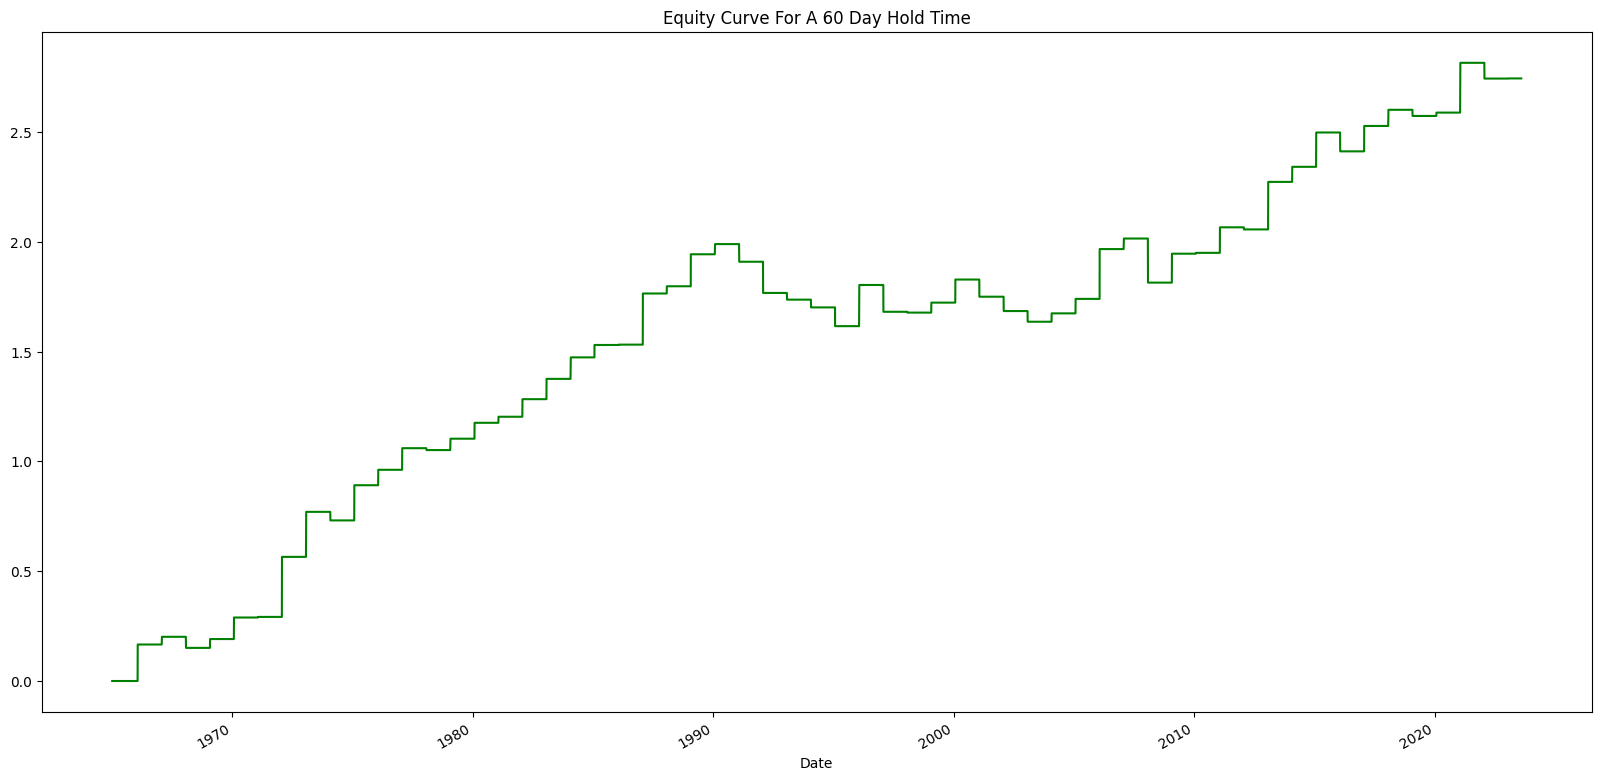

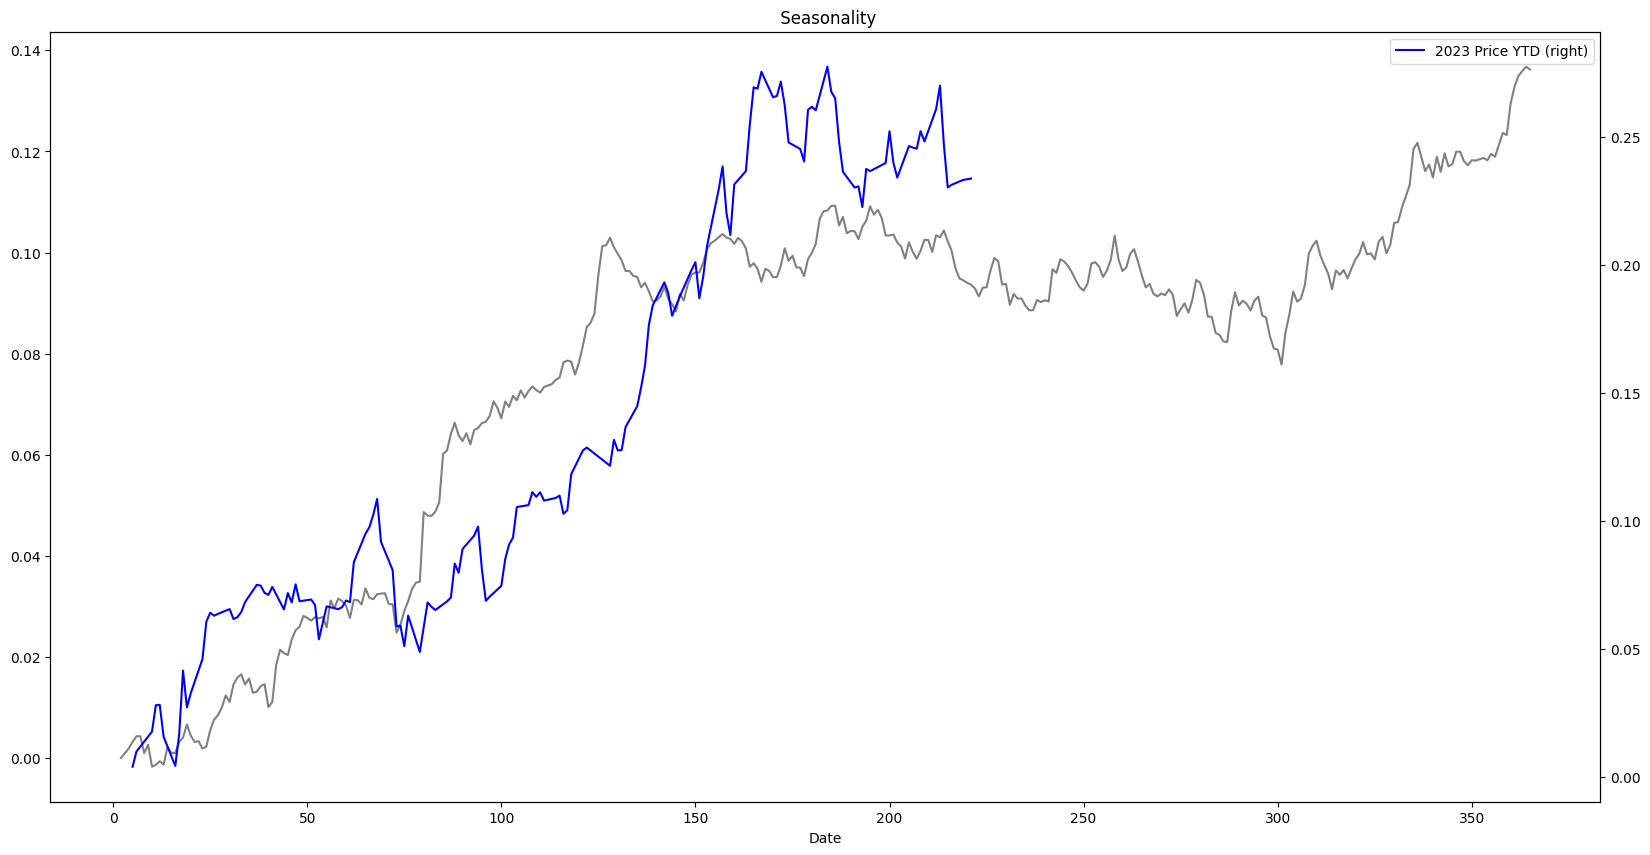

In [10]:
%pylab inline
import matplotlib
width, height = 20, 10 # example with 15x6 inches
matplotlib.rcParams['figure.figsize'] = [width, height]
tail = 9000
titleplot = " "
df['Close'].tail(tail).plot(color='black', title=titleplot)

df['Close'].where(df['condition']==True).tail(tail).plot(marker='$O$', linestyle=":", 
                                                           color='r', ms=15)
plt.yscale('log')
plt.show()



hold_time = 60
df['Close'].pct_change(periods=hold_time).where(df['condition'].shift(hold_time)==True).fillna(0).cumsum().plot(color='g', title='Equity Curve For A ' + str(hold_time) + ' Day Hold Time')
plt.show()

df['Close'].pct_change().groupby(lambda x: x.dayofyear).mean().cumsum().plot(title=" Seasonality", color='gray', label='Seasonal Composite')
df['Close'].where(df.index.year==2023).dropna().groupby(lambda x: x.dayofyear).min().pct_change().cumsum().plot(secondary_y=True, label='2023 Price YTD', legend=True, color='blue')
plt.show()


